In [34]:
import math
import pandas as pd
import networkx as nx
import igraph as ig
import leidenalg as la
from ipysigma import Sigma, SigmaGrid
from pelote import filter_edges, triangular_strength, read_graphology_json, global_threshold_sparsification, multiscale_backbone, graph_to_edges_dataframe
from pelote.graph import union_of_maximum_spanning_trees
from heapq import nlargest
from fog.metrics.utils import intersection_size
from fog.metrics import jaccard_similarity
from ebbe import partitioned_items
from collections import Counter

Sigma.set_defaults(max_categorical_colors=25)

def wdist(g):
    return graph_to_edges_dataframe(g).weight.plot.hist()

# Layout Weighting

In [5]:
corpus = read_graphology_json('NETWORK_CorpusMedia_DEFACTO_medialab_SciencesPo_V1.json')

for _, attr in corpus.nodes.data():
    del attr["x"]
    del attr["y"]
    del attr["color"]

## Normal

In [6]:
Sigma(corpus)

Sigma(nx.DiGraph with 732 nodes and 27,556 edges)

## Triangular strength and simmelian redundancies

In [58]:
def directed_simmelian_redudancies(graph: nx.Graph, m: int = 3, weights=None, direction = 'all', continuous: bool = False, exp=1):
    weights = triangular_strength(graph) if weights is None else weights

    neighbor_fn = graph.neighbors

    if direction == 'in':
        neighbor_fn = graph.predecessors
    elif direction == 'out':
        neighbor_fn = graph.successors

    NN = {}

    for node in graph:
        weighted_neighbors = sorted(
            [(neighbor, weights[(node, neighbor) if node < neighbor else (neighbor, node)]) for neighbor in neighbor_fn(node)],
            key=lambda t: t[1],
            reverse=True
        )
        best_neighbors = weighted_neighbors[:m]

        # NOTE: ties must be included
        if len(best_neighbors) < len(weighted_neighbors):
            best_weight = best_neighbors[-1][1]
            i = len(best_neighbors)

            while i < len(weighted_neighbors):
                n = weighted_neighbors[i]
                
                if n[1] == best_weight:
                    best_neighbors.append(n)
                else:
                    break

                i += 1
        
        NN[node] = [n[0] for n in best_neighbors]

    redundancies = {}

    for n1, n2 in graph.edges():
        if n1 > n2:
            (n1, n2) = (n2, n1)

        if continuous:
            r = jaccard_similarity(NN[n1], NN[n2])
        else:  
            r = intersection_size(NN[n1], NN[n2])
            
        redundancies[(n1, n2)] = r ** exp

    return redundancies

<Axes: ylabel='Frequency'>

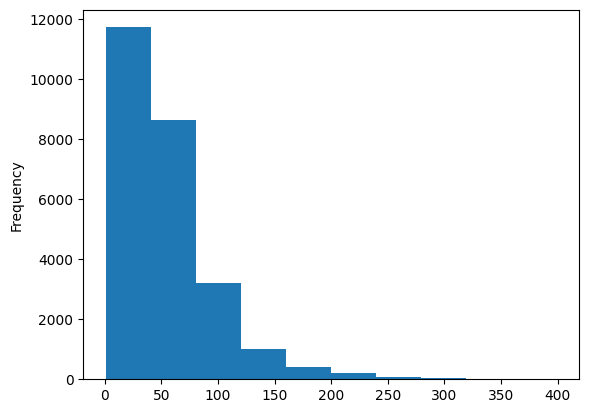

In [47]:
pd.Series(list(triangular_strength(corpus).values())).plot.hist()

<Axes: ylabel='Frequency'>

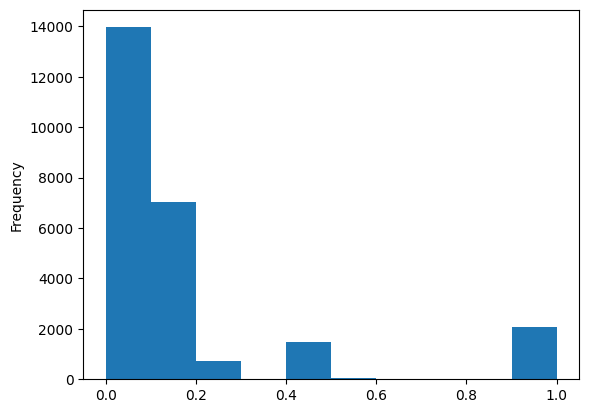

In [54]:
pd.Series(list(directed_simmelian_redudancies(corpus, continuous=True, m=3).values())).plot.hist()

In [77]:
def WeightedSigma(g, w, **kwargs):
    return Sigma(
        corpus,
        edge_weight=w,
        default_node_border_color='white',
        edge_zindex=w,
        edge_color=w,
        edge_color_gradient=("#ccc", "black"),
        node_size=g.degree,
        node_size_range=(2, 7),
        node_metrics=['louvain'],
        node_color='louvain',
        **kwargs
    )

In [73]:
def triangular_embeddedness(g):
    W1 = triangular_strength(g)
    W2 = {}

    S = {}

    for n in g:
        S[n] = sum(W1[(u, v) if u < v else (v, u)] for u, v in g.edges(n))

    for (u, v), w in W1.items():
        d = math.sqrt(S[u] * S[v])

        if d == 0:
            W2[u, v] = 0
        else:
            W2[u, v] = w / math.sqrt(S[u] * S[v])

    return W2

<Axes: ylabel='Frequency'>

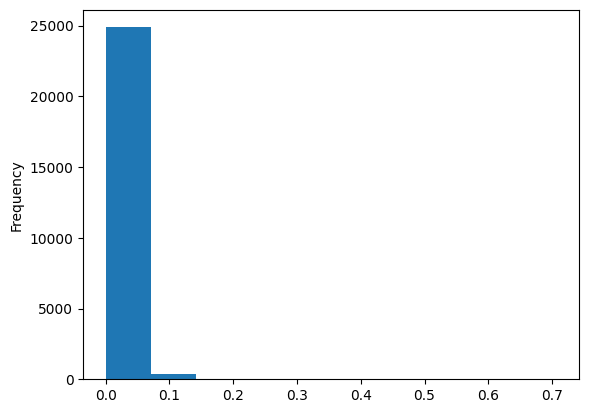

In [74]:
pd.Series(list(triangular_embeddedness(corpus).values())).plot.hist()

In [80]:
WeightedSigma(corpus, triangular_embeddedness(corpus))

Sigma(nx.DiGraph with 732 nodes and 27,556 edges)

In [60]:
WeightedSigma(corpus, directed_simmelian_redudancies(corpus, m=1000, direction='in', continuous=False, exp=3))

Sigma(nx.DiGraph with 732 nodes and 27,556 edges)